In [1]:
#install dependencies
# !pip3 install numpy scipy matplotlib schemdraw

import numpy as np
import matplotlib.pyplot as plt
import itertools

# !python3 -m pip install --upgrade pip
# !python3 -m pip install jax jaxlib

import jax
import jax.numpy as jnp
from jax import random, lax, vmap
from jax import jit

SEPARATED VERSION INTO CELLS

In [2]:
#generating random spin configuration
def initialize_spins(key, L):
    spins = random.choice(key, jnp.array([-1, 1]), shape=(L, L))  #randomly choosing between -1 and 1
    return spins

In [3]:
@jit  #hamiltonian function
def hamiltonian(spins, theta):
    L = spins.shape[0]
    H = -theta * jnp.sum(spins * (jnp.roll(spins, 1, axis=-2) + jnp.roll(spins, 1, axis=-2)), axis=(-2, -1))
    return H

In [4]:
@jit
def proposal(key, L):
    return random.randint(key, (2,), 0, L) #randomly choosing which bit to flip

In [5]:
@jit  #single Metropolis-Hastings step
def step(state, _):
    spins, beta, key, theta = state
    L = spins.shape[0]
    i, j = proposal(key, L)  #proposing  which bit to flip
    
    #change in energy
    delta_E = 2 * theta * spins[i, j] * (spins[i, (j+1) % L] + spins[i, (j-1) % L] + spins[(i+1) % L, j] + spins[(i-1) % L, j])
    
    key, subkey = random.split(key)
    accept = (delta_E < 0) | (random.uniform(subkey) < jnp.exp(-beta * delta_E))
    spins = spins.at[i, j].set(lax.select(accept, -spins[i, j], spins[i, j]))
    return (spins, beta, key, theta), accept


In [6]:
#single temperature MCMC process

def single_temperature_mcmc(L, iterations, T, step_recording, theta, thermalization, key):
    beta = 1.0 / T
    spins = initialize_spins(key, L)
    state = (spins, beta, key, theta)
    
    #thermalization
    state, accepts = lax.scan(step, state, None, length=thermalization)
    
    num_samples = (iterations - thermalization) // step_recording
    all_samples = jnp.zeros((num_samples, L, L))
    energies = []

    #sampling with step recording
    @jit
    def sampling_update(state, step_idx):
        state, _ = lax.scan(step, state, None, length=step_recording)
        all_samples = state[0]
        energy = hamiltonian(state[0], theta)
        energies.append(energy)
        return state, (all_samples, energy)
    
    state, results = lax.scan(sampling_update, state, jnp.arange(num_samples))
    all_samples, energies = results
    
    avg_energy = jnp.mean(energies)
    avg_energy_squared = jnp.mean(energies**2)
    final_spins = state[0]
    
    return avg_energy, avg_energy_squared, all_samples, key, jnp.array(energies)


In [7]:
#energy
def O(x, theta):
        return hamiltonian(x, theta)
    
#energy squared
def O_squared(x, theta):
        return (hamiltonian(x, theta))**2

In [8]:
#energy gradient w.r.t temperature dE/dT
def compute_energy_gradient(T, samples, theta, O):

    #model
    def log_p(T, x):
            return -1/T * hamiltonian(x, theta)

    N = len(samples)
    O_values = O(samples, theta)
    ō = jnp.mean(O_values)
    ΔO = O_values - ō
    gradient = jax.vjp(log_p, T, samples)[1](ΔO/ N) 

    return ō, gradient[0]

In [9]:
#heat capacity gradient w.r.t temperature dC/dT
def compute_heat_capacity_gradient(T, samples, theta):

    e, grad_e = compute_energy_gradient(T, samples, theta, O)
    e2, grad_e2 = compute_energy_gradient(T, samples, theta, O_squared)

    heat_capacity = (e2 - e**2)/(T**2)

    term1 = -2./T * heat_capacity
    term2 = 1/(T**2) * (grad_e2 -2 * e * grad_e)
    dC = term1 +  term2

    return dC, heat_capacity

In [10]:
#CHANGED THE THERMALIZATION FROM 0.3->0.35, STEP_RECODING FROM 15->20

L = 12  #grid size
iterations = 200000
thermalization = int(0.35 * iterations)
step_recording = 20
temperature_range = jnp.linspace(0.1, 10.0, 50)
theta = 1.0
k_B = 1.0
T_c = 2 * theta / (k_B * jnp.log(1 + jnp.sqrt(2)))

In [12]:
# ------------------------ PERFORMING MCMC
all_energies = jnp.zeros(len(temperature_range))
all_energies_squared = jnp.zeros(len(temperature_range))
all_samples_list = []

key = random.PRNGKey(0)

for idx, T in enumerate(temperature_range):
    key, subkey = random.split(key)
    avg_energy, avg_energy_squared, samples, key, energies = single_temperature_mcmc(L, iterations, T, step_recording, theta, thermalization, subkey)
    
    all_energies = all_energies.at[idx].set(avg_energy)
    all_energies_squared = all_energies_squared.at[idx].set(avg_energy_squared)
    all_samples_list.append(samples)

all_samples = jnp.concatenate(all_samples_list, axis=0)  

average_energies = all_energies
average_energies_squared = all_energies_squared

heat_capacities = (average_energies_squared - average_energies**2) / (temperature_range**2)
heat_capacity_variance = (average_energies_squared - average_energies**2) / (temperature_range**4)

print(all_samples.shape)

(325000, 12, 12)


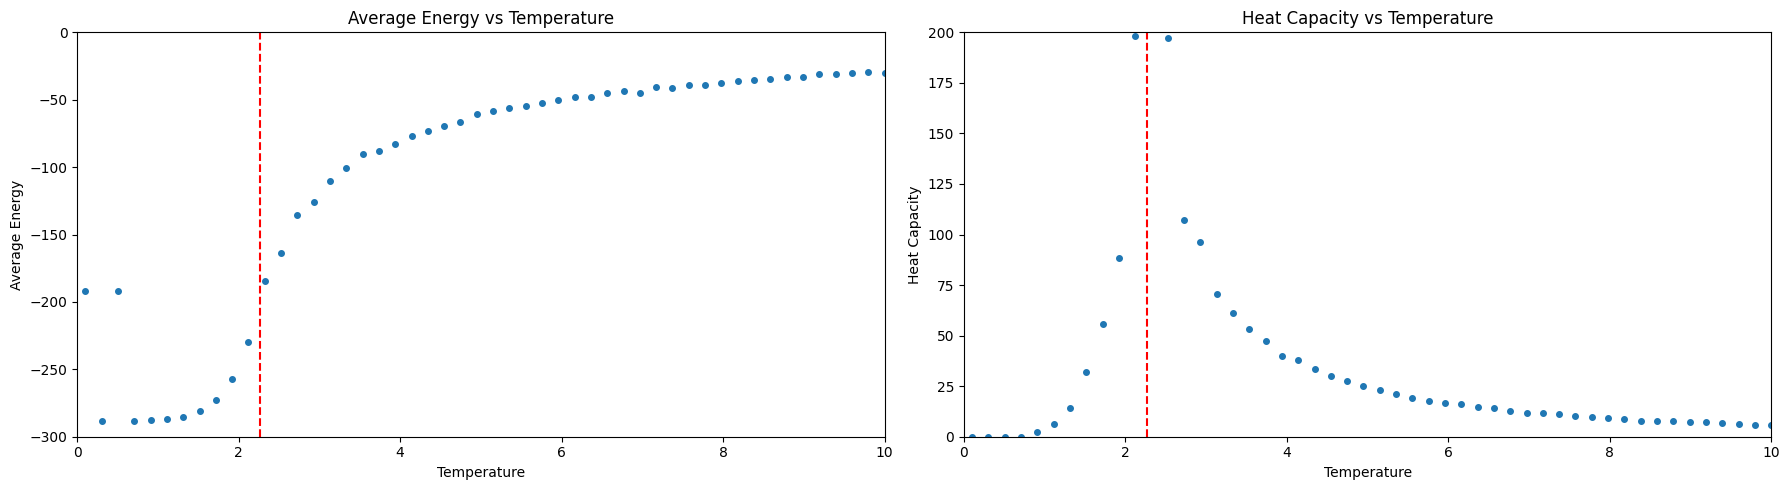

In [13]:
#------------------------ PLOTTING
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

#plot Average Energy vs Temperature
axes[0].errorbar(temperature_range, average_energies, fmt='o', markersize=4)
axes[0].axvline(x=T_c, color='red', linestyle='--')
axes[0].set_xlim(0, 10)
axes[0].set_ylim(-300, 0)
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Average Energy')
axes[0].set_title('Average Energy vs Temperature')

#plot Heat Capacity vs Temperature
axes[1].errorbar(temperature_range, heat_capacities, fmt='o', markersize=4)
axes[1].axvline(x=T_c, color='red', linestyle='--')
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 200)
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Heat Capacity')
axes[1].set_title('Heat Capacity vs Temperature')

plt.tight_layout()
plt.show()

In [14]:
#capturing spin configurations at specific times
def capture_spin_configurations(L, iterations, temperature, theta, capture_times):
    key = random.PRNGKey(0)
    beta = 1.0 / temperature
    spins = initialize_spins(key, L)
    state = (spins, beta, key, theta)

    configurations = []
    current_iteration = 0
    for capture_time in capture_times:
        while current_iteration < capture_time:
            state, _ = lax.scan(step, state, None, length=capture_time - current_iteration)
            current_iteration = capture_time
        configurations.append(state[0])

    return configurations

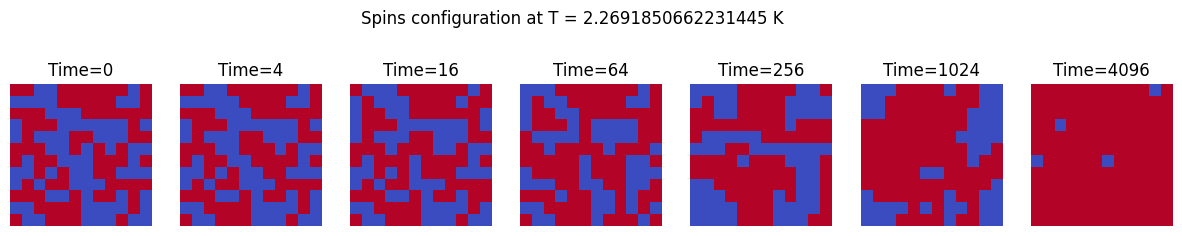

In [13]:
#------------------------ SPINS CONFIGURATION

temperature = T_c
capture_times = [0, 4, 16, 64, 256, 1024, 4096]
configurations = capture_spin_configurations(L, iterations, temperature, theta, capture_times)

#plotting spin configurations
fig, axes = plt.subplots(1, len(capture_times), figsize=(15, 3))
for ax, spins, time in zip(axes, configurations, capture_times):
    ax.imshow(spins, cmap='coolwarm')
    ax.set_title(f'Time={time}')
    ax.axis('off')
plt.suptitle(f'Spins configuration at T = {temperature} K')
plt.show()

In [19]:
# ------------------------ GRADIENTS

#at random temperature gradient_temperature
gradient_temperature = 2.567056894302368
key = jax.random.PRNGKey(0)
key, subkey = random.split(key)
avg_energy, avg_energy_squared, samples_2, key, energies = single_temperature_mcmc(L, iterations, gradient_temperature, step_recording, theta, thermalization, subkey)
heat_capacity_gradient, hc = compute_heat_capacity_gradient(gradient_temperature, samples_2, theta)
print(f"Heat capacity gradient at random temperature of value {gradient_temperature} is {heat_capacity_gradient}.")

#at critical temperature T_c
key = jax.random.PRNGKey(0)
key, subkey = random.split(key)
avg_energy, avg_energy_squared, samples_3, key, energies = single_temperature_mcmc(L, iterations, T_c, step_recording, theta, thermalization, subkey)
print("")
heat_capacity_gradient_critical, hc = compute_heat_capacity_gradient(T_c, samples_3, theta)
print(f"Heat capacity gradient at critical temperature of value {T_c} is {heat_capacity_gradient_critical}.")

Heat capacity gradient at random temperature of value 2.567056894302368 is -166.32586669921875.

Heat capacity gradient at critical temperature of value 2.2691850662231445 is 50.91325378417969.


In [15]:
#--------------------- GRADIENT ASCENT

def gradient_ascent(learning_rate, initial_temperature, num_steps, L, iterations, step_recording, theta, thermalization):
    key = random.PRNGKey(0)
    T = initial_temperature

    temperatures = jnp.zeros(num_steps)
    heat_capacities = jnp.zeros(num_steps)

    @jit
    def body_fun(i, val):
        T, key, temps, hcs = val
        key, subkey = random.split(key)

        avg_energy, avg_energy_squared, samples_ascent, key, energies = single_temperature_mcmc(L, iterations, T, step_recording, theta, thermalization, subkey)
        
        heat_capacity_gradient, hc = compute_heat_capacity_gradient(T, samples_ascent, theta)

        new_temp = T + learning_rate * heat_capacity_gradient
        new_temp = jnp.clip(new_temp, 0.1, 10.0)  #stays within bounds

        temps = temps.at[i].set(new_temp)
        hcs = hcs.at[i].set(hc)

        return new_temp, key, temps, hcs

    final_T, _, temperatures, heat_capacities = jax.lax.fori_loop(0, num_steps, body_fun, (T, key, temperatures, heat_capacities))
    return final_T, temperatures, heat_capacities

In [16]:
def perform_gradient_ascent(num_steps, starting_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c):

    optimized_temperature, all_temperatures, all_heat_capacities = gradient_ascent(learning_rate, starting_temperature, num_steps, L, iterations, step_recording, theta, thermalization)

    #bootstrap resampling
    n_bootstrap = 50
    bootstrap_samples = np.random.choice(all_heat_capacities, (n_bootstrap, num_steps), replace=True) #n_bootstrap rows (bootstrap samples) and num_steps columns
    error_bars = np.std(bootstrap_samples, axis=0)

    print(f"Optimized temperature for maximum heat capacity is: {optimized_temperature}")
    print(f"Critical temperature is: {T_c}")
    print("")
    print(f"Difference between optimized and critical temperature is: {optimized_temperature - T_c}")

    return all_temperatures, all_heat_capacities, error_bars

In [17]:
def plot_gradient_ascent_results(all_temperatures, all_heat_capacities, T_c, error_bars):

    time_points = np.arange(len(all_heat_capacities))

    plt.figure(figsize=(10, 5))
    plt.fill_between(time_points[::10], (all_heat_capacities - error_bars)[::10], (all_heat_capacities + error_bars)[::10], color='red', alpha=0.4, label='Error')
    plt.plot(time_points[::10], all_heat_capacities[::10], label='Heat Capacity')  #plot every 10th point
    plt.xlabel('Time')
    plt.ylabel('Heat Capacity')
    plt.title('Temperature vs Heat Capacity (Gradient Ascent Process)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(all_heat_capacities, markersize=3)
    plt.xlabel('Time')
    plt.ylabel('Heat Capacity')
    plt.title('Temperature vs Heat Capacity (Gradient Ascent Process)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(all_temperatures, markersize=3)
    plt.axhline(y=T_c, color='red', linestyle='--', label='Critical Temperature')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title('Temperature vs Heat Capacity (Gradient Ascent Process)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [18]:
num_steps = 1000
starting_temperature = 5.0
learning_rate = 0.0005

all_temperatures, all_heat_capacities, error_bars = perform_gradient_ascent(num_steps, starting_temperature, learning_rate, L, iterations, step_recording, theta, thermalization, T_c)

Optimized temperature for maximum heat capacity is: 2.3221688270568848
Critical temperature is: 2.2691850662231445

Difference between optimized and critical temperature is: 0.052983760833740234


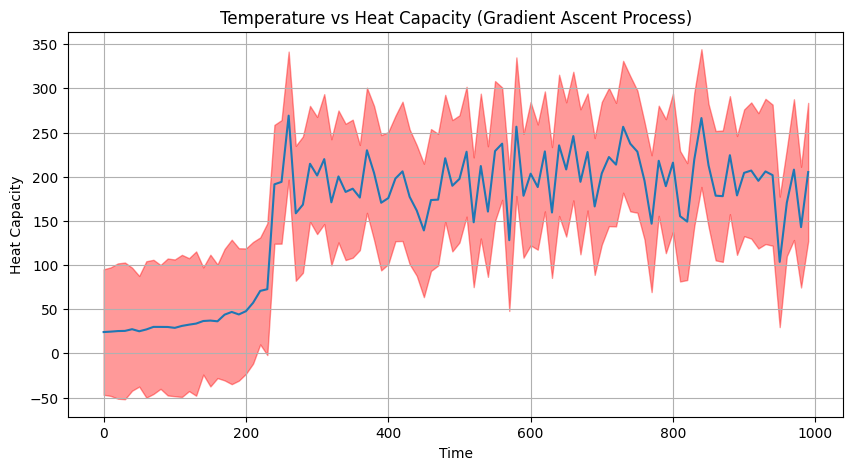

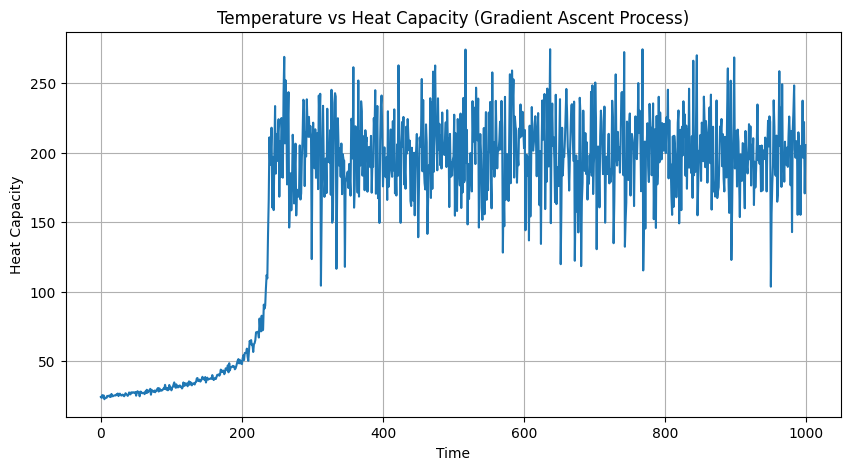

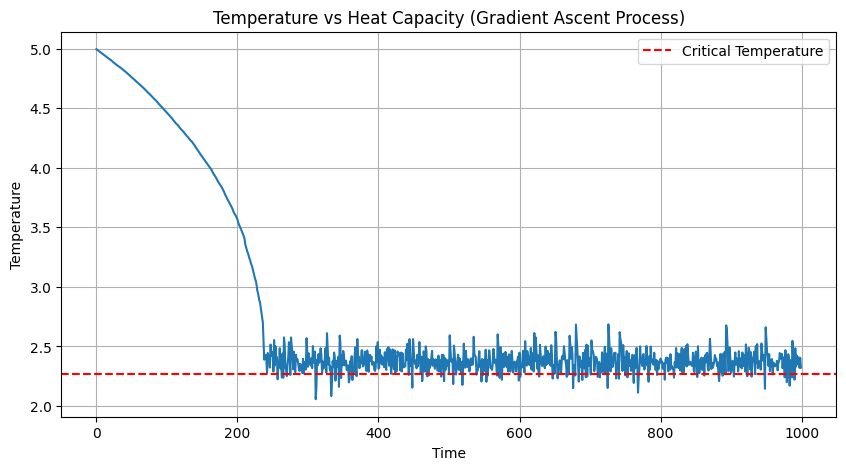

In [19]:
#plotting results
plot_gradient_ascent_results(all_temperatures, all_heat_capacities, T_c, error_bars)

TESTING

In [11]:
# full summation
#T = 2.566443681716919
T = 2.0
theta = 1.

L = 2
N = L**2

@jit  # Hamiltonian function
def hamiltonian(spins, theta):
    L = spins.shape[0]
    H = -theta * jnp.sum(spins * (jnp.roll(spins, 1, axis=-2) + jnp.roll(spins, 1, axis=-2)), axis=(-2, -1))
    return H

def log_p(T, x):
    return -1/T * hamiltonian(x, theta)

basis = 2**jnp.arange(N)

def numbers_to_states(i):
    return 2*(jax.lax.bitwise_and(i[:,None], basis[None]) !=0).astype(np.int8).reshape(-1, L, L)-1

def states_to_numbers(x):
    x = (1+x.reshape(-1, L**2)//2).astype(jnp.uint32)
    basis = 2**jnp.arange(L**2)
    return x@basis

all_states = numbers_to_states(jnp.arange(2**N))

def expval_fullsum(O, x, T):
    exponent = log_p(T, x)
    pdf = jnp.exp(exponent - jax.scipy.special.logsumexp(exponent))
    return O(x)@pdf



In [12]:
from functools import partial

Energy at critical temperature is: -7.208155155181885


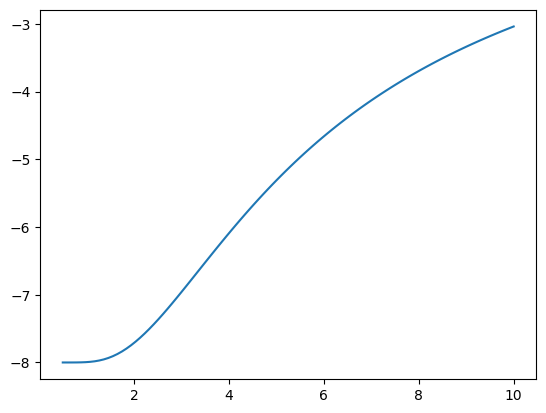

In [13]:
ts = np.linspace(0.5,10,100)
e = jax.vmap(lambda t: expval_fullsum(partial(hamiltonian, theta=1), all_states, t))(ts)
plt.plot(ts, e)

temp = 2.691850662231445
index = (np.abs(ts - temp)).argmin()
energy = e[index]
print(f"Energy at critical temperature is: {energy}")


In [14]:
ts = np.linspace(0.5,10,100)
grad_e_fn = jax.grad(lambda t: expval_fullsum(partial(hamiltonian, theta=1), all_states, t))
grad_e = jax.vmap(grad_e_fn)(ts)

print(f"Gradient of energy at critical temperature is:", grad_e_fn(2.2691850662231445))

Gradient of energy at critical temperature is: 0.6905058


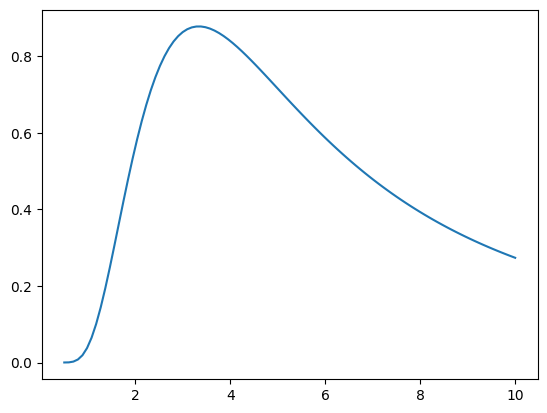

In [15]:
def heat_capacity(x, T):
    E = expval_fullsum(partial(hamiltonian, theta=1), x, T)
    E_sq = expval_fullsum(lambda x: hamiltonian(x, theta=1)**2, x, T)
    return (E_sq - E**2)/(T**2)
hc = jax.vmap(lambda t: heat_capacity(all_states, t))(ts)
plt.plot(ts, hc)

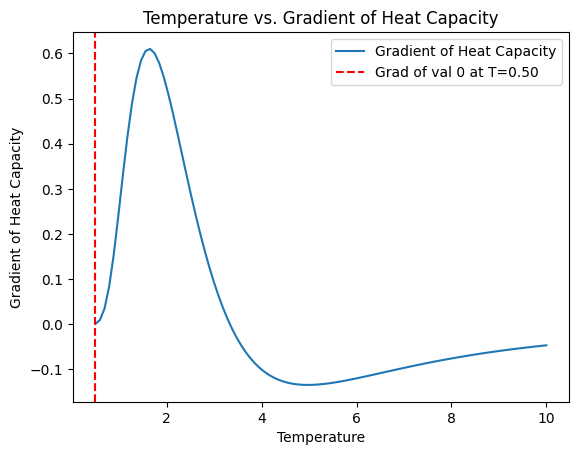

In [16]:
grad_hc_fn = jax.grad(partial(heat_capacity, all_states))
grad_hc = jax.vmap(grad_hc_fn)(ts)

plt.plot(ts, grad_hc, label='Gradient of Heat Capacity')

zero_crossing_temp = ts[jnp.argmin(jnp.abs(grad_hc))]

plt.axvline(x=zero_crossing_temp, color='red', linestyle='--', label=f'Grad of val 0 at T={zero_crossing_temp:.2f}')

plt.xlabel('Temperature')
plt.ylabel('Gradient of Heat Capacity')
plt.title('Temperature vs. Gradient of Heat Capacity')
plt.legend()



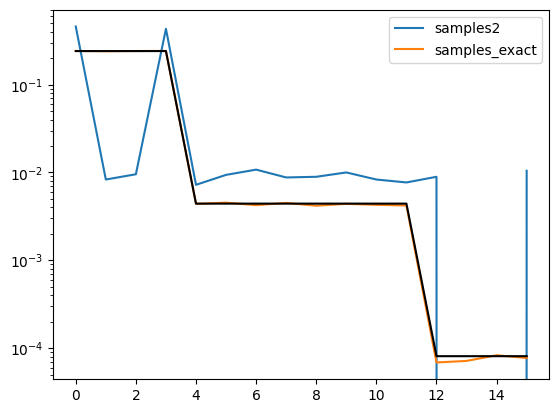

In [21]:
# exact sampling
T = 2.0

key = jax.random.PRNGKey(0)
key, subkey = random.split(key)
avg_energy, avg_energy_squared, samples_test, key, energies = single_temperature_mcmc(L, iterations, T, step_recording, theta, thermalization, subkey)

def exact_sampling(T, n_samples):
    exponent = log_p(T, all_states)
    pdf = jnp.exp(exponent - jax.scipy.special.logsumexp(exponent))
    
    samples_exact_i = jax.random.choice(jax.random.key(123), a=len(pdf), p=pdf, replace=True, shape=(n_samples,))
    samples_exact = numbers_to_states(samples_exact_i)
    return samples_exact, pdf

samples_exact, pdf = exact_sampling(T, 350000)

perm = jnp.argsort(pdf)[::-1]

plt.plot((np.bincount(states_to_numbers(samples_test))/len(samples_test))[perm], label='samples2')
plt.plot((np.bincount(states_to_numbers(samples_exact))/len(samples_exact))[perm], label='samples_exact')
plt.legend()
plt.plot(pdf[perm], color='k', label='exact')
plt.yscale('log')

In [22]:
#my code and my function
T=2.566443681716919

avg_energy, avg_energy_squared, samples_test, key, energies = single_temperature_mcmc(L, iterations, T, step_recording, theta, thermalization, subkey)

compute_heat_capacity_gradient(T, samples_test, theta)

(Array(1.334497, dtype=float32), Array(2.3930464, dtype=float32))

In [23]:
#exact sampling using my function

samples_exact = exact_sampling(T, 350000)
compute_heat_capacity_gradient(T, samples_exact, theta)

AttributeError: 'tuple' object has no attribute 'shape'

In [24]:
#full summation

grad_hc_fn(T)

Array(0.26221395, dtype=float32, weak_type=True)